In [49]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook


%matplotlib inline

In [50]:
np.random.seed(2019)
tf.set_random_seed(2019)
NSIZE = 224
PREPROCESS_GAMMAX=10
BATCH_SIZE =32
SEED=2019

In [51]:

train_df = pd.read_csv('./aptos2019/train.csv')
print(train_df.shape)
train_df.head()
def get_label(diagnosis):
    return [i for i in range(diagnosis + 1)]
train_df['label'] = train_df.diagnosis.apply(get_label)
train_df['id_code'] = train_df['id_code'].apply(lambda x:  x + '.png')
print(train_df.head(10))

(3662, 2)
            id_code  diagnosis            label
0  000c1434d8d7.png          2        [0, 1, 2]
1  001639a390f0.png          4  [0, 1, 2, 3, 4]
2  0024cdab0c1e.png          1           [0, 1]
3  002c21358ce6.png          0              [0]
4  005b95c28852.png          0              [0]
5  0083ee8054ee.png          4  [0, 1, 2, 3, 4]
6  0097f532ac9f.png          0              [0]
7  00a8624548a9.png          2        [0, 1, 2]
8  00b74780d31d.png          2        [0, 1, 2]
9  00cb6555d108.png          1           [0, 1]


# Preprocessing


In [85]:

def ben_color (img) :
    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , PREPROCESS_GAMMAX) ,-4 ,128)
    return img
def preprocess_image(img, color=False):
    def crop_image_from_gray(img,tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol

            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0): # image is too dark so that we crop out everything,
                return img # return original image
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img
    def circle_crop(img, sigmaX=10):   
        """
        Create circular crop around image centre    
        """    

        img = crop_image_from_gray(img)    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, depth = img.shape    

        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))

        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (NSIZE, NSIZE))
        return img 
    img = crop_image_from_gray(img)
    
    img = cv2.resize(img, (NSIZE, NSIZE))
    img = ben_color(img)
    #im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return img


CPU times: user 4.76 s, sys: 164 ms, total: 4.92 s
Wall time: 3.6 s


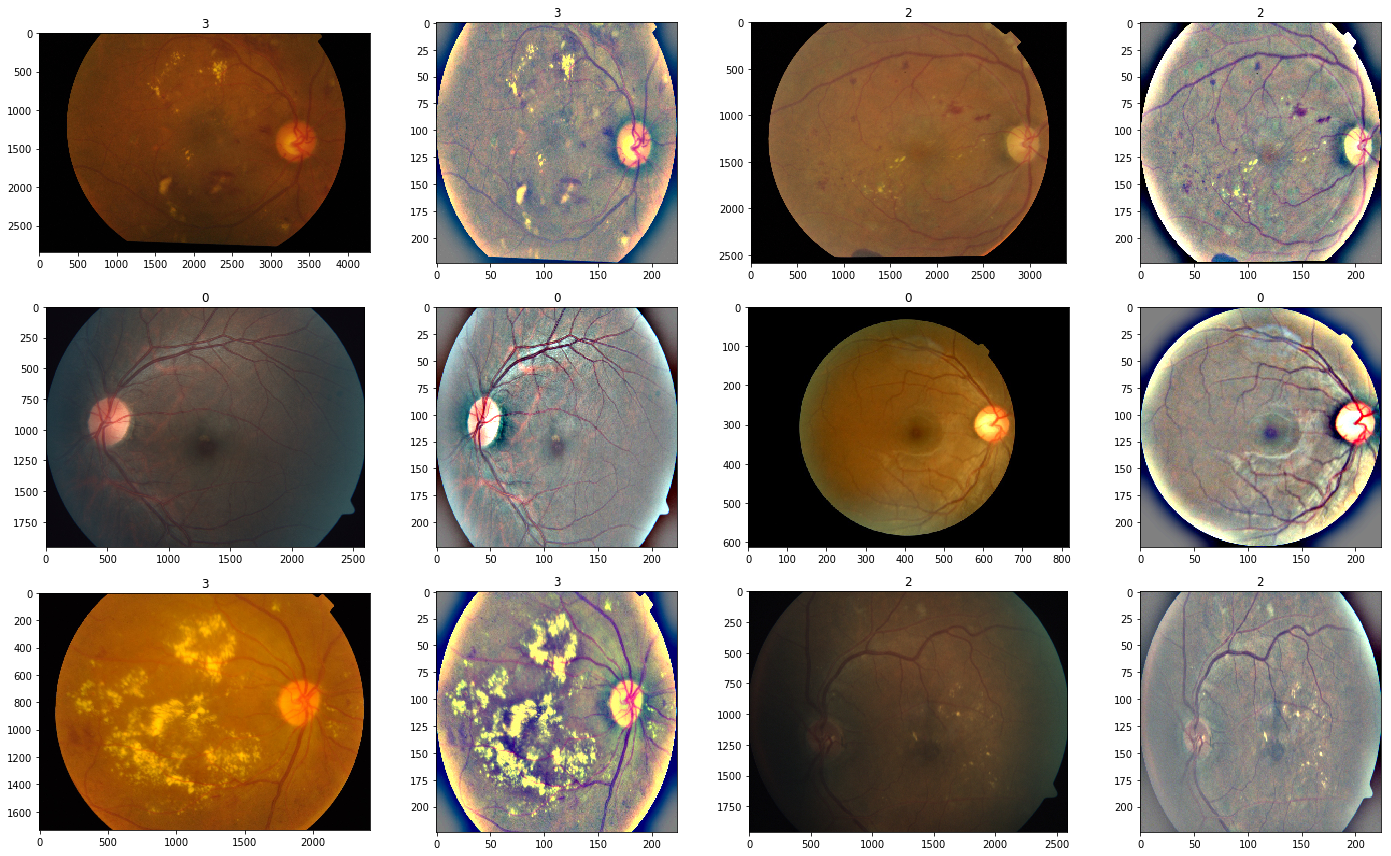

In [93]:
%%time
def preprocess_display(df, columns=4, rows=15, desired_size=NSIZE):
    
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows)[::2]:
        image_path = df.loc[i+200,'id_code']
        image_id = df.loc[i+200,'diagnosis']

        img = cv2.imread(f'./aptos2019/train_images/{image_path}')

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgProc = preprocess_image(img)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
        fig.add_subplot(rows, columns, i+2)
        plt.title(image_id)
        plt.imshow(imgProc)
    plt.tight_layout()

preprocess_display(train_df)

## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [54]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(y_train.shape)

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=1))
print("Multilabel version:", y_train_multi.sum(axis=1))

(3662, 5)
Original y_train: [1 1 1 ... 1 1 1]
Multilabel version: [3 5 2 ... 3 1 3]


In [55]:
def create_datagen():
    return ImageDataGenerator(
        zoom_range=[0.85,1],  # set range for random zoom
        #rotation_range=30,
        fill_mode="nearest",
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=preprocess_image,
        validation_split=0.15
        
    )

data_gen=create_datagen().flow_from_dataframe(
    dataframe=train_df, 
    directory="./aptos2019/train_images/", 
    x_col='id_code', 
    y_col='label', 
    class_mode="categorical", 
    batch_size=BATCH_SIZE,
    target_size=(NSIZE,NSIZE),
    subset="training",
    seed=SEED)

val_gen=create_datagen().flow_from_dataframe(
    dataframe=train_df, 
    directory="./aptos2019/train_images/", 
    x_col='id_code', 
    y_col='label', 
    class_mode="categorical", 
    batch_size=128,
    target_size=(NSIZE,NSIZE),
    subset="validation",
    seed=SEED)


Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
W0810 16:46:07.792579 140302805448448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 16:46:07.806354 140302805448448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 16:46:07.820029 140302805448448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 16:46:07.834727 140302805448448 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0810 16:46:07.848489 140302805448448 image.py:648] Clipping input data to the valid range for imshow with R

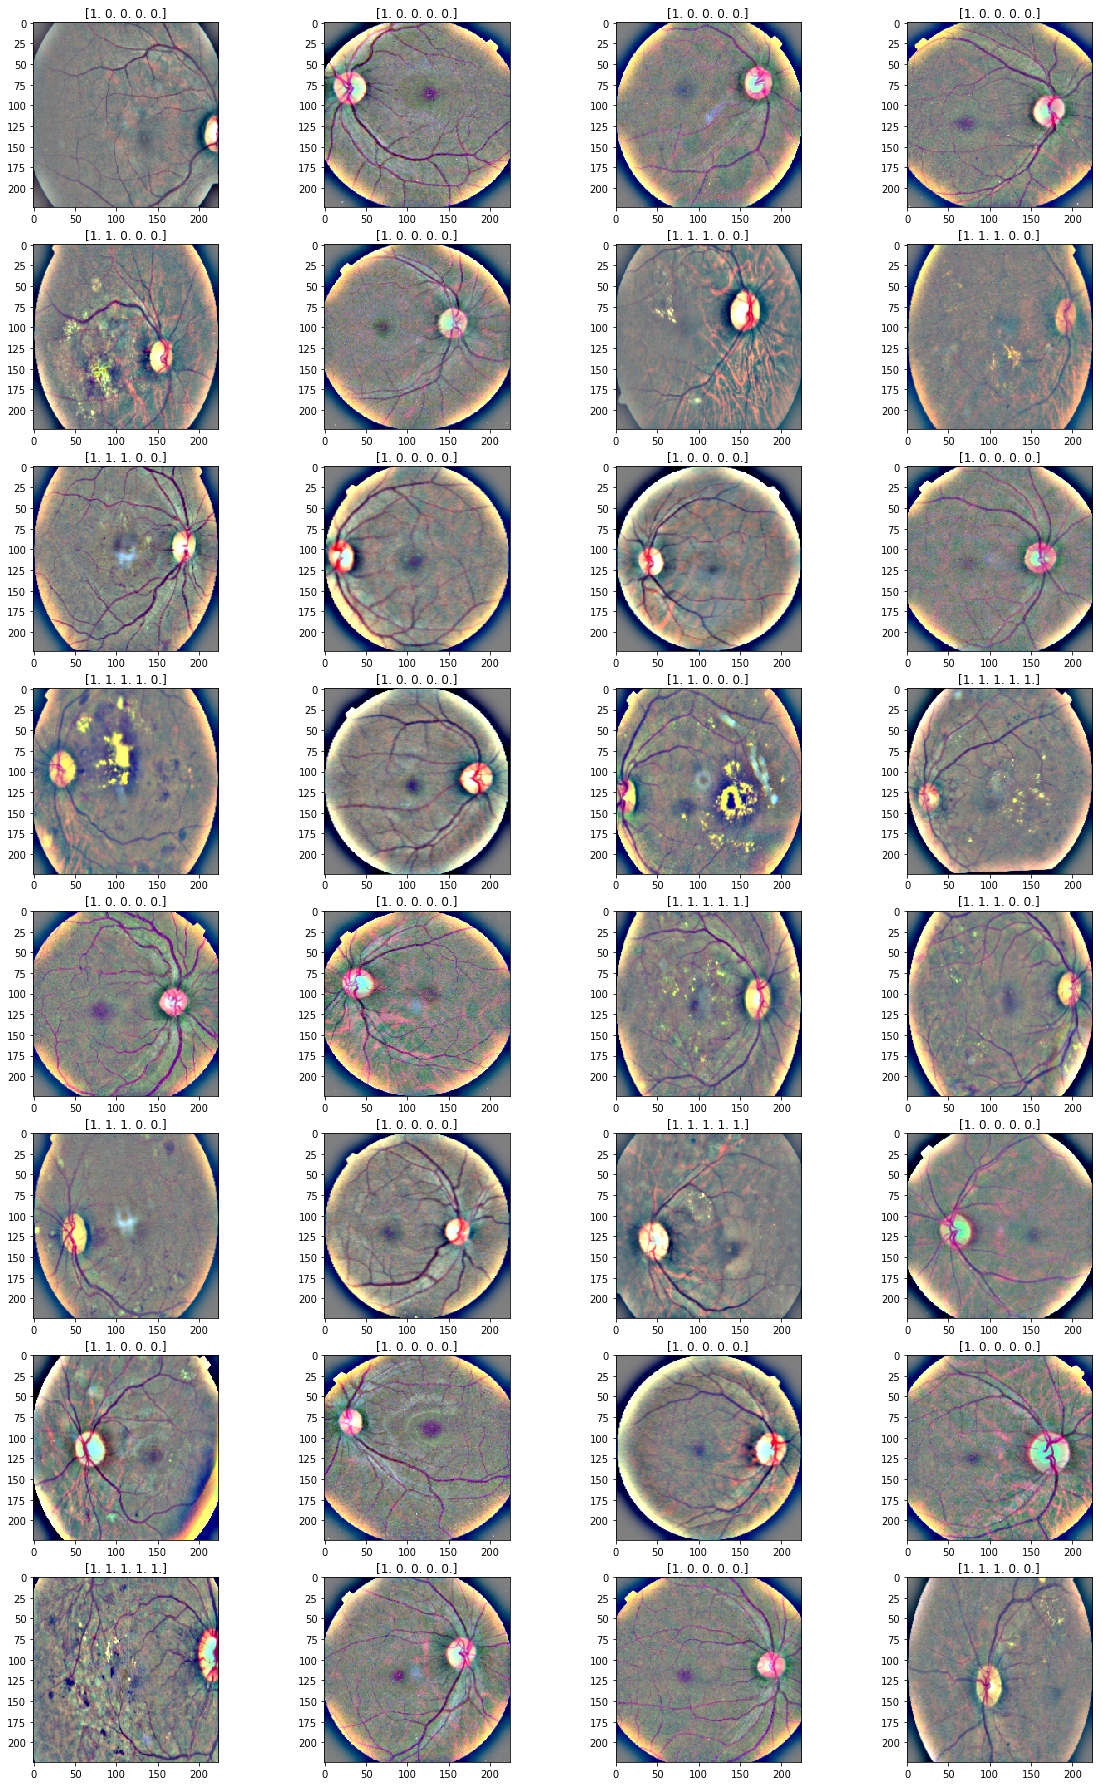

In [56]:
def display_generated_image(data_generator):
    for X, Y in data_generator:
        columns = 4
        rows = 8
        fig=plt.figure(figsize=(5*columns, 4*rows))
        for i in range(columns*rows):
            img = np.asarray(X[i].reshape(NSIZE,NSIZE,3),np.int32)

            fig.add_subplot(rows, columns, i+1)
            plt.title(Y[i])
            plt.imshow(img)

        plt.show()
        break
display_generated_image(data_gen)

In [72]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    #y_val= np.argmax(y_val, axis=1)
    return y_val

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        for X_val, y_val in val_gen:
            y_val = label_convert(y_val)
            
            y_pred = self.model.predict(X_val) > 0.5
            y_pred = label_convert(y_pred)

            _val_kappa = cohen_kappa_score(
                y_val,
                y_pred, 
                weights='quadratic'
            )

            self.val_kappas.append(_val_kappa)

            print(f"val_kappa: {_val_kappa:.4f}")

            if _val_kappa == max(self.val_kappas):
                print("Validation Kappa has improved. Saving model.")
                self.model.save('densenet_model.h5')
            break

    
    

[3 3 4 0 2 2 0 0 0 2 2 0 2 2 4 2 4 2 1 0 2 0 0 0 0 4 0 2 2 2 4 0 0 2 3 1 0
 0 3 4 1 2 1 2 4 0 2 2 0 0 3 0 0 2 0 0 1 0 2 0 2 3 2 2 0 0 0 2 2 2 1 2 2 1
 2 4 2 2 2 0 0 0 0 0 2 0 3 2 4 4 0 0 1 4 0 4 0 0 2 4 4 0 1 2 0 0 0 0 1 0 2
 2 2 0 4 1 2 0 2 0 0 2 0 1 4 0 2 0]


In [58]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [59]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [60]:
kappa_metrics = Metrics()

STEP_SIZE_TRAIN=data_gen.n//data_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

history = model.fit_generator(
    data_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=15,
    validation_data=val_gen,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[kappa_metrics],
    verbose=1
)

Epoch 1/15
97/97 [==============================] - 404s 4s/step - loss: 0.4856 - acc: 0.7675 - val_loss: 0.3364 - val_acc: 0.8578
val_kappa: 0.7282
Validation Kappa has improved. Saving model.
Epoch 2/15
97/97 [==============================] - 357s 4s/step - loss: 0.1726 - acc: 0.9368 - val_loss: 0.1627 - val_acc: 0.9425
val_kappa: 0.8655
Epoch 4/15
97/97 [==============================] - 353s 4s/step - loss: 0.1480 - acc: 0.9447 - val_loss: 0.1544 - val_acc: 0.9316
val_kappa: 0.8155
Epoch 5/15
97/97 [==============================] - 354s 4s/step - loss: 0.1282 - acc: 0.9529 - val_loss: 0.1535 - val_acc: 0.9344
val_kappa: 0.7904
Epoch 6/15
97/97 [==============================] - 361s 4s/step - loss: 0.1178 - acc: 0.9540 - val_loss: 0.1675 - val_acc: 0.9363
val_kappa: 0.8637
Epoch 7/15
97/97 [==============================] - 356s 4s/step - loss: 0.1054 - acc: 0.9618 - val_loss: 0.1447 - val_acc: 0.9363
val_kappa: 0.8535
Epoch 8/15
97/97 [==============================] - 357s 4s/s

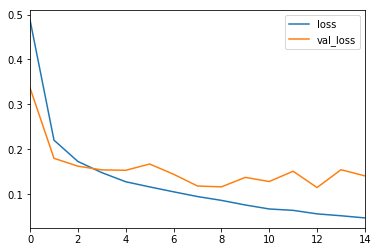

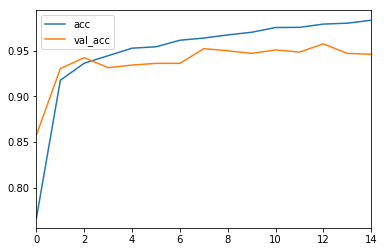

In [61]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

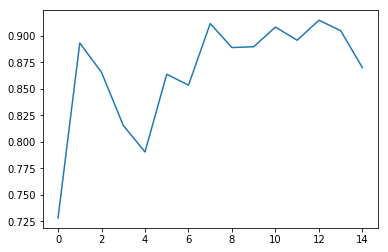

In [62]:
plt.plot(kappa_metrics.val_kappas)

In [66]:
model.load_weights('densenet_model.h5')


test_df = pd.read_csv('./aptos2019/test.csv')
test_df.head()
test_df['id_code'] = test_df['id_code'].apply(lambda x:  x + '.png')

test_datagen=ImageDataGenerator(
        preprocessing_function=preprocess_image,
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory="./aptos2019/test_images/", 
    x_col='id_code', 
    y_col=None,
    shuffle=False,
    class_mode=None,
    batch_size=1,
    target_size=(NSIZE,NSIZE)
)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


predict_output=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Found 1928 validated image filenames.
1928/1928 [==============================] - 89s 46ms/step


In [73]:

y_test= label_convert(predict_output > 0.5)
print(predict_output)

test_df = pd.read_csv('./aptos2019/test.csv')
print(y_test.shape)
test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)
print(test_df)

[[0.9981649  0.9986054  0.14613312 0.00336009 0.00270455]
 [0.9989125  0.9999027  0.9961207  0.26853758 0.00903425]
 [0.99955857 0.99996054 0.9967744  0.36532378 0.01032066]
 ...
 [0.9994074  0.99993193 0.99564636 0.05706692 0.00236848]
 [0.99938154 0.99991494 0.99815416 0.86990035 0.47346038]
 [0.9992564  0.0639891  0.00506631 0.0031516  0.01730404]]
(1928,)
           id_code  diagnosis
0     0005cfc8afb6          1
1     003f0afdcd15          2
2     006efc72b638          2
3     00836aaacf06          2
4     009245722fa4          2
5     009c019a7309          2
6     010d915e229a          3
7     0111b949947e          0
8     01499815e469          3
9     0167076e7089          0
10    01c31b10ab99          1
11    01c5ba195207          2
12    01e4d86b3a30          2
13    020921b796d5          2
14    020f6983114d          2
15    021c207614d6          2
16    0229c0a80d42          2
17    024d0a225db1          2
18    0268f4382c67          2
19    0299d97f31f7          0
20    03